참고한 글: https://3months.tistory.com/168

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, GRU, Dropout
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping

<AxesSubplot:>

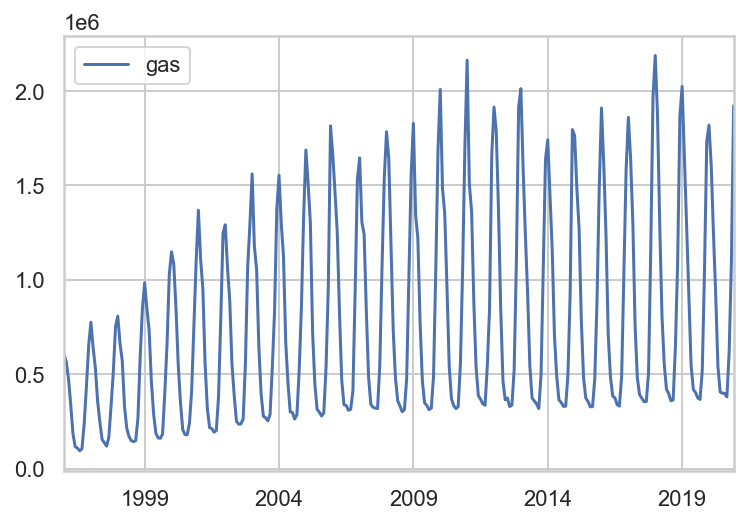

In [2]:
data = pd.read_csv('월별공급량및비중all.csv')
data["ID"] = pd.date_range("1996-01-01", "2020-12-01", freq="MS")
civil = data["도시가스(톤)_민수용"]
civil.index = data["ID"]
civil = civil.to_frame()
civil.columns=['gas']
civil.index = pd.DatetimeIndex(civil.index.values,
                               freq=civil.index.inferred_freq)
civil.plot()

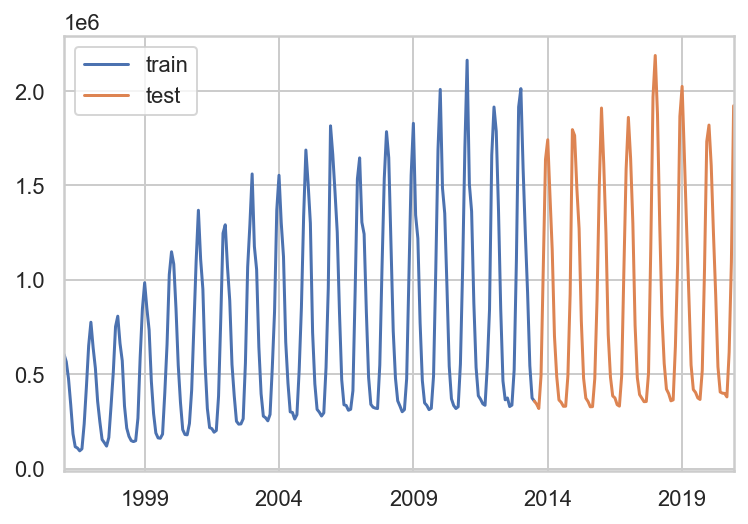

In [3]:
split_date = pd.Timestamp('07-01-2013')
train = civil.loc[:split_date]
test = civil.loc[split_date:]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [4]:
sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)
train_sc, test_sc

(array([[0.24702465],
        [0.2280687 ],
        [0.18511893],
        [0.1175476 ],
        [0.04342227],
        [0.01048487],
        [0.00712759],
        [0.        ],
        [0.00503303],
        [0.06892207],
        [0.16427444],
        [0.26913139],
        [0.32924143],
        [0.26403065],
        [0.2116798 ],
        [0.12707007],
        [0.074283  ],
        [0.02895962],
        [0.0209475 ],
        [0.01208033],
        [0.03397379],
        [0.11493412],
        [0.20119106],
        [0.31797164],
        [0.34470323],
        [0.27504363],
        [0.23059416],
        [0.11468361],
        [0.05819152],
        [0.03710378],
        [0.02603904],
        [0.02360789],
        [0.02591089],
        [0.08361637],
        [0.23934477],
        [0.36323021],
        [0.43030099],
        [0.3642579 ],
        [0.30932743],
        [0.17764507],
        [0.09487842],
        [0.04567448],
        [0.03309409],
        [0.03218391],
        [0.04272537],
        [0

In [5]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head(), test_sc_df.head()

(              Scaled
 1996-01-01  0.247025
 1996-02-01  0.228069
 1996-03-01  0.185119
 1996-04-01  0.117548
 1996-05-01  0.043422,
               Scaled
 2013-07-01  0.127418
 2013-08-01  0.119932
 2013-09-01  0.108397
 2013-10-01  0.192527
 2013-11-01  0.466645)

In [6]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)
    
train_sc_df.head(13)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
1996-01-01,0.247025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-02-01,0.228069,0.247025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-01,0.185119,0.228069,0.247025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-04-01,0.117548,0.185119,0.228069,0.247025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-05-01,0.043422,0.117548,0.185119,0.228069,0.247025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-06-01,0.010485,0.043422,0.117548,0.185119,0.228069,0.247025,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-07-01,0.007128,0.010485,0.043422,0.117548,0.185119,0.228069,0.247025,NaN,NaN,NaN,NaN,NaN,NaN
1996-08-01,0.000000,0.007128,0.010485,0.043422,0.117548,0.185119,0.228069,0.247025,NaN,NaN,NaN,NaN,NaN
1996-09-01,0.005033,0.000000,0.007128,0.010485,0.043422,0.117548,0.185119,0.228069,0.247025,NaN,NaN,NaN,NaN
1996-10-01,0.068922,0.005033,0.000000,0.007128,0.010485,0.043422,0.117548,0.185119,0.228069,0.247025,NaN,NaN,NaN


In [7]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
Y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
Y_test = test_sc_df.dropna()[['Scaled']]

X_train.head(), Y_train.head()

(             shift_1   shift_2   shift_3   shift_4   shift_5   shift_6  \
 1997-01-01  0.269131  0.164274  0.068922  0.005033  0.000000  0.007128   
 1997-02-01  0.329241  0.269131  0.164274  0.068922  0.005033  0.000000   
 1997-03-01  0.264031  0.329241  0.269131  0.164274  0.068922  0.005033   
 1997-04-01  0.211680  0.264031  0.329241  0.269131  0.164274  0.068922   
 1997-05-01  0.127070  0.211680  0.264031  0.329241  0.269131  0.164274   
 
              shift_7   shift_8   shift_9  shift_10  shift_11  shift_12  
 1997-01-01  0.010485  0.043422  0.117548  0.185119  0.228069  0.247025  
 1997-02-01  0.007128  0.010485  0.043422  0.117548  0.185119  0.228069  
 1997-03-01  0.000000  0.007128  0.010485  0.043422  0.117548  0.185119  
 1997-04-01  0.005033  0.000000  0.007128  0.010485  0.043422  0.117548  
 1997-05-01  0.068922  0.005033  0.000000  0.007128  0.010485  0.043422  ,
               Scaled
 1997-01-01  0.329241
 1997-02-01  0.264031
 1997-03-01  0.211680
 1997-04-01  0.

In [8]:
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values

print(X_train.shape)
print(X_train)
print(Y_train.shape)
print(Y_train)

(199, 12)
[[0.26913139 0.16427444 0.06892207 ... 0.18511893 0.2280687  0.24702465]
 [0.32924143 0.26913139 0.16427444 ... 0.1175476  0.18511893 0.2280687 ]
 [0.26403065 0.32924143 0.26913139 ... 0.04342227 0.1175476  0.18511893]
 ...
 [0.40450327 0.55428509 0.72175819 ... 0.13530805 0.13063241 0.17888072]
 [0.2177028  0.40450327 0.55428509 ... 0.1133435  0.13530805 0.13063241]
 [0.13523551 0.2177028  0.40450327 ... 0.11701175 0.1133435  0.13530805]]
(199, 1)
[[0.32924143]
 [0.26403065]
 [0.2116798 ]
 [0.12707007]
 [0.074283  ]
 [0.02895962]
 [0.0209475 ]
 [0.01208033]
 [0.03397379]
 [0.11493412]
 [0.20119106]
 [0.31797164]
 [0.34470323]
 [0.27504363]
 [0.23059416]
 [0.11468361]
 [0.05819152]
 [0.03710378]
 [0.02603904]
 [0.02360789]
 [0.02591089]
 [0.08361637]
 [0.23934477]
 [0.36323021]
 [0.43030099]
 [0.3642579 ]
 [0.30932743]
 [0.17764507]
 [0.09487842]
 [0.04567448]
 [0.03309409]
 [0.03218391]
 [0.04272537]
 [0.14862838]
 [0.27207905]
 [0.45101538]
 [0.50954157]
 [0.47784756]
 [0.3

In [9]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)
print("최종 DATA")
print(X_train_t.shape)
print(X_train_t)
print(Y_train)

최종 DATA
(199, 12, 1)
[[[0.26913139]
  [0.16427444]
  [0.06892207]
  ...
  [0.18511893]
  [0.2280687 ]
  [0.24702465]]

 [[0.32924143]
  [0.26913139]
  [0.16427444]
  ...
  [0.1175476 ]
  [0.18511893]
  [0.2280687 ]]

 [[0.26403065]
  [0.32924143]
  [0.26913139]
  ...
  [0.04342227]
  [0.1175476 ]
  [0.18511893]]

 ...

 [[0.40450327]
  [0.55428509]
  [0.72175819]
  ...
  [0.13530805]
  [0.13063241]
  [0.17888072]]

 [[0.2177028 ]
  [0.40450327]
  [0.55428509]
  ...
  [0.1133435 ]
  [0.13530805]
  [0.13063241]]

 [[0.13523551]
  [0.2177028 ]
  [0.40450327]
  ...
  [0.11701175]
  [0.1133435 ]
  [0.13530805]]]
[[0.32924143]
 [0.26403065]
 [0.2116798 ]
 [0.12707007]
 [0.074283  ]
 [0.02895962]
 [0.0209475 ]
 [0.01208033]
 [0.03397379]
 [0.11493412]
 [0.20119106]
 [0.31797164]
 [0.34470323]
 [0.27504363]
 [0.23059416]
 [0.11468361]
 [0.05819152]
 [0.03710378]
 [0.02603904]
 [0.02360789]
 [0.02591089]
 [0.08361637]
 [0.23934477]
 [0.36323021]
 [0.43030099]
 [0.3642579 ]
 [0.30932743]
 [0.177

In [10]:
print(X_train_t.shape[1:])

(12, 1)


In [11]:
K.clear_session()

model = Sequential()
model.add(LSTM(300, input_shape=(12,1), return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(300, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 300)           362400    
                                                                 
 dropout (Dropout)           (None, 12, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 300)               721200    
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 1,083,901
Trainable params: 1,083,901
Non-trainable params: 0
_________________________________________________________________


In [12]:
early_stop = EarlyStopping(monitor='loss', patience=30, verbose=1)
h = model.fit(X_train_t, Y_train, epochs=300, validation_data=[X_test_t, Y_test],
         batch_size=10, verbose=1, callbacks=[early_stop])

Epoch 1/300
20/20 [==============================] - 4s 68ms/step - loss: 0.0783 - val_loss: 0.0959
Epoch 2/300
20/20 [==============================] - 1s 42ms/step - loss: 0.0572 - val_loss: 0.0968
Epoch 3/300
20/20 [==============================] - 1s 38ms/step - loss: 0.0551 - val_loss: 0.0611
Epoch 4/300
20/20 [==============================] - 1s 42ms/step - loss: 0.0350 - val_loss: 0.0291
Epoch 5/300
20/20 [==============================] - 1s 44ms/step - loss: 0.0149 - val_loss: 0.0099
Epoch 6/300
20/20 [==============================] - 1s 38ms/step - loss: 0.0210 - val_loss: 0.0247
Epoch 7/300
20/20 [==============================] - 1s 39ms/step - loss: 0.0080 - val_loss: 0.0084
Epoch 8/300
20/20 [==============================] - 1s 38ms/step - loss: 0.0050 - val_loss: 0.0039
Epoch 9/300
20/20 [==============================] - 1s 39ms/step - loss: 0.0041 - val_loss: 0.0082
Epoch 10/300
20/20 [==============================] - 1s 47ms/step - loss: 0.0052 - val_loss: 0.0043

Minimum Train Loss: 0.0015
Minimum Validation Loss: 0.0016
dict_keys(['loss', 'val_loss'])


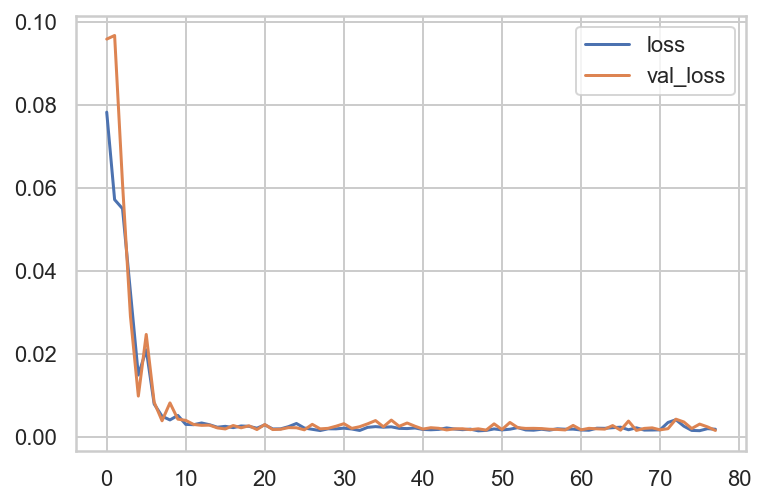

In [13]:
history_df=pd.DataFrame(h.history)
print("Minimum Train Loss: {:0.4f}".format(history_df['loss'].min()))
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print(h.history.keys())
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

In [14]:
Y_pred = model.predict(X_test_t)
print("Loss: ", model.evaluate(X_test_t,Y_test))
print(Y_pred)
print(Y_test)

3/3 [==============================] - 0s 23ms/step - loss: 0.0016
Loss:  0.0015891402726992965
[[0.10196895]
 [0.09491371]
 [0.12018196]
 [0.20309754]
 [0.43184006]
 [0.71702534]
 [0.85386306]
 [0.71228474]
 [0.5426627 ]
 [0.34929037]
 [0.20138076]
 [0.13681382]
 [0.1101748 ]
 [0.1002888 ]
 [0.12225975]
 [0.20106472]
 [0.422386  ]
 [0.72648567]
 [0.8193838 ]
 [0.74553776]
 [0.5954658 ]
 [0.38374415]
 [0.20989154]
 [0.13904907]
 [0.11117525]
 [0.09923425]
 [0.11667481]
 [0.18502302]
 [0.4021869 ]
 [0.77097344]
 [0.8543868 ]
 [0.738017  ]
 [0.5757745 ]
 [0.37041554]
 [0.20279285]
 [0.13768847]
 [0.1105211 ]
 [0.10035204]
 [0.12247094]
 [0.2013268 ]
 [0.42239866]
 [0.81658804]
 [0.91136426]
 [0.7749482 ]
 [0.61534864]
 [0.3889167 ]
 [0.22688313]
 [0.16089739]
 [0.13265115]
 [0.12113331]
 [0.1436529 ]
 [0.2297313 ]
 [0.5410385 ]
 [0.8668227 ]
 [0.9636689 ]
 [0.7983928 ]
 [0.6025583 ]
 [0.37642184]
 [0.21377878]
 [0.14532208]
 [0.11829632]
 [0.10845118]
 [0.13130486]
 [0.21118754]
 [0.4406

In [15]:
y_pred = sc.inverse_transform(Y_pred)
y_test = sc.inverse_transform(Y_test)
print(y_pred, y_test)

[[ 305581.38]
 [ 290992.97]
 [ 343241.2 ]
 [ 514689.1 ]
 [ 987669.4 ]
 [1577358.8 ]
 [1860303.6 ]
 [1567556.4 ]
 [1216821.9 ]
 [ 816978.  ]
 [ 511139.25]
 [ 377631.53]
 [ 322548.97]
 [ 302107.25]
 [ 347537.5 ]
 [ 510485.78]
 [ 968120.8 ]
 [1596920.2 ]
 [1789009.5 ]
 [1636315.  ]
 [1326005.  ]
 [ 888219.5 ]
 [ 528737.3 ]
 [ 382253.47]
 [ 324617.62]
 [ 299926.72]
 [ 335989.28]
 [ 477315.7 ]
 [ 926354.4 ]
 [1688909.4 ]
 [1861386.6 ]
 [1620764.  ]
 [1285288.5 ]
 [ 860659.4 ]
 [ 514059.1 ]
 [ 379440.1 ]
 [ 323265.  ]
 [ 302238.  ]
 [ 347974.16]
 [ 511027.7 ]
 [ 968147.  ]
 [1783228.6 ]
 [1979201.2 ]
 [1697128.1 ]
 [1367117.6 ]
 [ 898915.  ]
 [ 563871.5 ]
 [ 427430.12]
 [ 369024.22]
 [ 345208.3 ]
 [ 391773.  ]
 [ 569760.8 ]
 [1213463.5 ]
 [1887100.9 ]
 [2087353.5 ]
 [1745605.5 ]
 [1340670.5 ]
 [ 873078.9 ]
 [ 536775.1 ]
 [ 395224.44]
 [ 339342.12]
 [ 318984.94]
 [ 366240.44]
 [ 531417.1 ]
 [1005913.25]
 [1791082.  ]
 [1995137.5 ]
 [1685328.  ]
 [1326651.4 ]
 [ 884653.56]
 [ 528190.06]
 [ 381

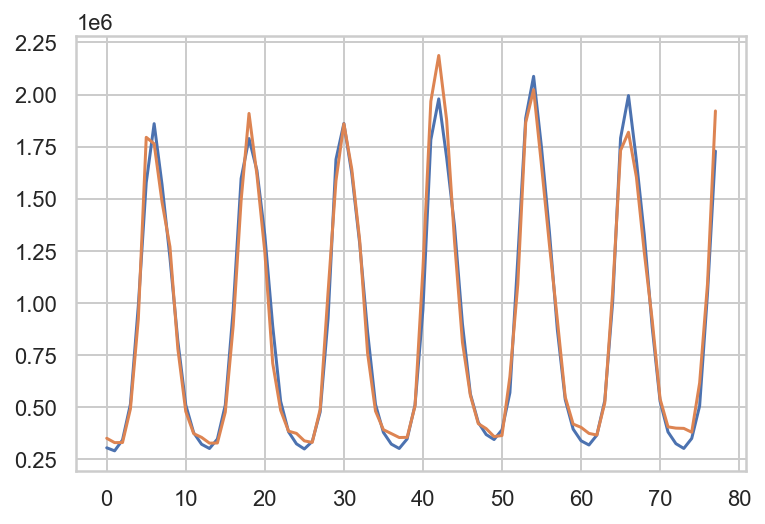

In [16]:
plt.figure()
plt.plot(y_pred)
plt.plot(y_test)

In [17]:
print(test_sc_df['2020-12-01':])
print(test_sc_df['2020-12-01':].shift(axis=1).drop('Scaled', axis=1).values)

new_X = test_sc_df['2020-12-01':].shift(axis=1).drop('Scaled', axis=1).values
new_X_t = new_X.reshape(new_X.shape[0], 12, 1)
print('new_X: ', new_X)
print('new_X_t: ', new_X_t)
print(new_X_t.shape)
print(type(new_X_t))

              Scaled   shift_1   shift_2   shift_3   shift_4   shift_5  \
2020-12-01  0.883412  0.483141  0.252423  0.138073  0.146984  0.147601   

             shift_6   shift_7   shift_8   shift_9  shift_10  shift_11  \
2020-12-01  0.150538  0.215105  0.398246  0.555391  0.730238  0.833947   

            shift_12  
2020-12-01  0.791884  
[[0.88341238 0.48314126 0.2524233  0.1380729  0.14698408 0.14760117
  0.1505382  0.21510479 0.3982462  0.55539112 0.73023846 0.83394729]]
new_X:  [[0.88341238 0.48314126 0.2524233  0.1380729  0.14698408 0.14760117
  0.1505382  0.21510479 0.3982462  0.55539112 0.73023846 0.83394729]]
new_X_t:  [[[0.88341238]
  [0.48314126]
  [0.2524233 ]
  [0.1380729 ]
  [0.14698408]
  [0.14760117]
  [0.1505382 ]
  [0.21510479]
  [0.3982462 ]
  [0.55539112]
  [0.73023846]
  [0.83394729]]]
(1, 12, 1)
<class 'numpy.ndarray'>


In [18]:
new_Y_pred = model.predict(new_X_t)
new_Y_pred

1/1 [==============================] - 0s 37ms/step


array([[0.91313577]], dtype=float32)

In [19]:
test_sc_df['2020-12-01':]

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
2020-12-01,0.883412,0.483141,0.252423,0.138073,0.146984,0.147601,0.150538,0.215105,0.398246,0.555391,0.730238,0.833947,0.791884


In [20]:
from pandas.tseries.offsets import DateOffset
pred_date = [test_sc_df.index[-1] + DateOffset(months=x) for x in range(0,169)]
pred_date = pd.DataFrame(index=pred_date[1:], columns=test_sc_df.columns)
pred_date.iloc[0,1:] = test_sc_df['2020-12-01':].shift(axis=1).drop('Scaled', axis=1)
print(pred_date)

new_X = np.reshape(pred_date.iloc[0,1:].values, (-1, 12, 1))
new_X = np.asarray(new_X).astype('float32')
print(new_X.shape)
print('new_X: ', new_X)

           Scaled   shift_1   shift_2   shift_3   shift_4   shift_5   shift_6  \
2021-01-01    NaN  0.883412  0.483141  0.252423  0.138073  0.146984  0.147601   
2021-02-01    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2021-03-01    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2021-04-01    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2021-05-01    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
...           ...       ...       ...       ...       ...       ...       ...   
2034-08-01    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2034-09-01    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2034-10-01    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2034-11-01    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2034-12-01    NaN       NaN       NaN       NaN       NaN       NaN       NaN   

             shift_7   shif

In [21]:
new_Y_pred = model.predict(new_X)
new_Y_pred

1/1 [==============================] - 0s 36ms/step


array([[0.91313577]], dtype=float32)

In [22]:
pred_date.iloc[0,0] = new_Y_pred[0][0]
pred_date

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
2021-01-01,0.913136,0.883412,0.483141,0.252423,0.138073,0.146984,0.147601,0.150538,0.215105,0.398246,0.555391,0.730238,0.833947
2021-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2034-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2034-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2034-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
for i in range(1, 168):
    pred_date.iloc[i, 1:] = pred_date.iloc[i-1][:-1].values
    new_X = np.reshape(pred_date.iloc[i, 1:].values, (-1, 12, 1))
    new_X = np.asarray(new_X).astype('float32')
    new_Y_pred = model.predict(new_X)
    pred_date.iloc[i,0] = new_Y_pred[0][0]
pred_date

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 26ms/step


,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
2021-01-01,0.913136,0.883412,0.483141,0.252423,0.138073,0.146984,0.147601,0.150538,0.215105,0.398246,0.555391,0.730238,0.833947
2021-02-01,0.776185,0.913136,0.883412,0.483141,0.252423,0.138073,0.146984,0.147601,0.150538,0.215105,0.398246,0.555391,0.730238
2021-03-01,0.605303,0.776185,0.913136,0.883412,0.483141,0.252423,0.138073,0.146984,0.147601,0.150538,0.215105,0.398246,0.555391
2021-04-01,0.389654,0.605303,0.776185,0.913136,0.883412,0.483141,0.252423,0.138073,0.146984,0.147601,0.150538,0.215105,0.398246
2021-05-01,0.21496,0.389654,0.605303,0.776185,0.913136,0.883412,0.483141,0.252423,0.138073,0.146984,0.147601,0.150538,0.215105
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034-08-01,0.111162,0.127565,0.164664,0.272244,0.48329,0.690479,0.857933,0.931288,0.696617,0.355828,0.17332,0.118711,0.111001
2034-09-01,0.117551,0.111162,0.127565,0.164664,0.272244,0.48329,0.690479,0.857933,0.931288,0.696617,0.355828,0.17332,0.118711
2034-10-01,0.168924,0.117551,0.111162,0.127565,0.164664,0.272244,0.48329,0.690479,0.857933,0.931288,0.696617,0.355828,0.17332
2034-11-01,0.343765,0.168924,0.117551,0.111162,0.127565,0.164664,0.272244,0.48329,0.690479,0.857933,0.931288,0.696617,0.355828


<AxesSubplot:>

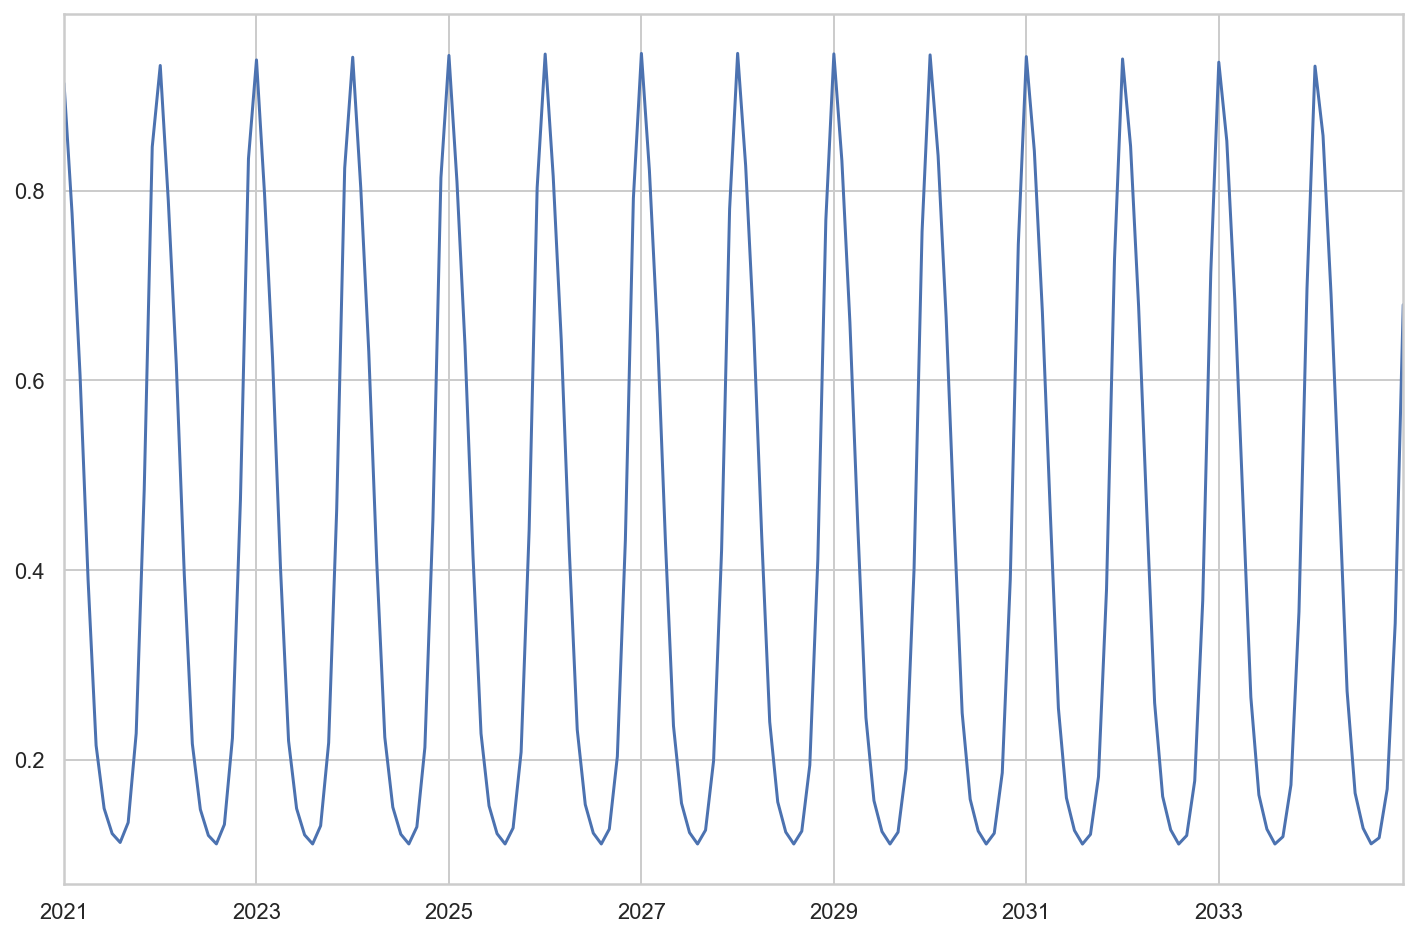

In [24]:
pred_date['Scaled'].plot(figsize=(12,8))

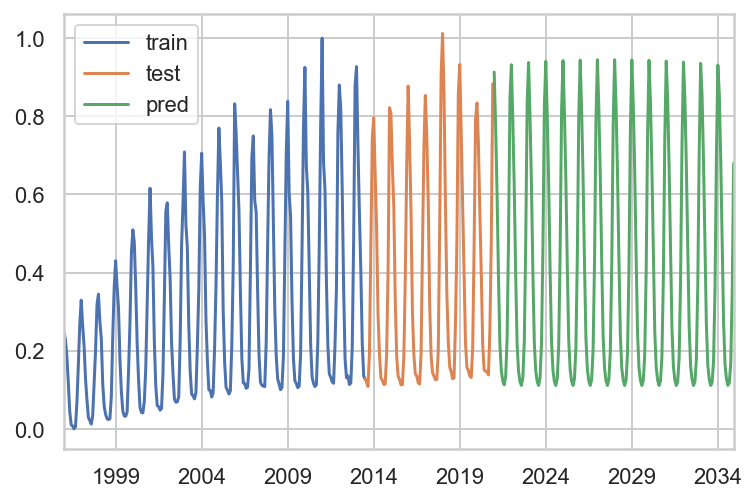

In [25]:
train_sc_df['Scaled'].plot()
test_sc_df['Scaled'].plot()
pred_date['Scaled'].plot()
plt.legend(['train', 'test','pred'])

In [26]:
tmp = np.reshape(pred_date['Scaled'].values, (1, -1))
pred = sc.inverse_transform(tmp)
pred_date['final'] = pred.flatten()
pred_date

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12,final
2021-01-01,0.913136,0.883412,0.483141,0.252423,0.138073,0.146984,0.147601,0.150538,0.215105,0.398246,0.555391,0.730238,0.833947,1.982864e+06
2021-02-01,0.776185,0.913136,0.883412,0.483141,0.252423,0.138073,0.146984,0.147601,0.150538,0.215105,0.398246,0.555391,0.730238,1.699686e+06
2021-03-01,0.605303,0.776185,0.913136,0.883412,0.483141,0.252423,0.138073,0.146984,0.147601,0.150538,0.215105,0.398246,0.555391,1.346345e+06
2021-04-01,0.389654,0.605303,0.776185,0.913136,0.883412,0.483141,0.252423,0.138073,0.146984,0.147601,0.150538,0.215105,0.398246,9.004386e+05
2021-05-01,0.21496,0.389654,0.605303,0.776185,0.913136,0.883412,0.483141,0.252423,0.138073,0.146984,0.147601,0.150538,0.215105,5.392181e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034-08-01,0.111162,0.127565,0.164664,0.272244,0.48329,0.690479,0.857933,0.931288,0.696617,0.355828,0.17332,0.118711,0.111001,3.245892e+05
2034-09-01,0.117551,0.111162,0.127565,0.164664,0.272244,0.48329,0.690479,0.857933,0.931288,0.696617,0.355828,0.17332,0.118711,3.378012e+05
2034-10-01,0.168924,0.117551,0.111162,0.127565,0.164664,0.272244,0.48329,0.690479,0.857933,0.931288,0.696617,0.355828,0.17332,4.440274e+05
2034-11-01,0.343765,0.168924,0.117551,0.111162,0.127565,0.164664,0.272244,0.48329,0.690479,0.857933,0.931288,0.696617,0.355828,8.055533e+05


In [27]:
final = pd.DataFrame()
final['YEAR'] = pred_date['final'].index.year
final['MONTH'] = pred_date['final'].index.month
final['CIVIL'] = pred_date['final'].values
final

,YEAR,MONTH,CIVIL
0,2021,1,1.982864e+06
1,2021,2,1.699686e+06
2,2021,3,1.346345e+06
3,2021,4,9.004386e+05
4,2021,5,5.392181e+05
...,...,...,...
163,2034,8,3.245892e+05
164,2034,9,3.378012e+05
165,2034,10,4.440274e+05
166,2034,11,8.055533e+05


In [28]:
final.to_csv("lstm.csv", mode='w', index=False)

In [29]:
# model.save('lstm_civil.h5')